Trabajo Práctico 4: Aprendizaje No-Supervisado - Lucas Pini

In [ ]:
# ====== Celda 1: imports y helpers ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple

np.set_printoptions(suppress=True, linewidth=120)
plt.rcParams["figure.dpi"] = 120
RNG_SEED = 0
rng = np.random.default_rng(RNG_SEED)

In [ ]:




# --- plots sin duplicado ---
def showfig(fig): 
    fig.tight_layout(); plt.show(); plt.close(fig)

# --- loader correcto: última columna = person_id ---
def load_faces_csv(path: str, label_col: Optional[str] = "person_id") -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(path)
    if label_col not in df.columns:
        # última columna por defecto
        label_col = df.columns[-1]
    y = df[label_col].to_numpy()
    X = df.drop(columns=[label_col]).to_numpy(dtype=np.float32)
    if X.size and X.max() > 1.0:
        X = X / 255.0
    return X, y

# --- split estratificado ---
def stratified_split(X, y, test_size=0.2, random_state=RNG_SEED):
    X = np.asarray(X); y = np.asarray(y)
    rng = np.random.default_rng(random_state)
    train_idx, test_idx = [], []
    for cls in np.unique(y):
        ii = np.where(y == cls)[0]
        rng.shuffle(ii)
        n_t = max(1, int(round(len(ii) * test_size)))
        test_idx.extend(ii[:n_t].tolist())
        train_idx.extend(ii[n_t:].tolist())
    return (X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])

# --- estandarización ---
def standardize_fit(X):
    mu = X.mean(0, keepdims=True)
    sd = X.std(0, ddof=1, keepdims=True)
    sd[sd==0] = 1.0
    return {"mu": mu, "sd": sd}
def standardize_transform(X, st):
    return (X - st["mu"]) / st["sd"]

# --- PCA por SVD (centrado interno) ---
def pca_fit(X):
    Xc = X - X.mean(0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    ev = (S**2)/(X.shape[0]-1)
    er = ev/ev.sum()
    return {"components": Vt, "cum_explained_ratio": np.cumsum(er), "mean": X.mean(0, keepdims=True)}
def pca_transform(X, pca, k):
    Xc = X - X.mean(0, keepdims=True)  # consistente con fit local
    W = pca["components"][:k]
    return Xc @ W.T
def pca_inverse(Z, pca, k, X_mean=None):
    W = pca["components"][:k]
    Xrec = Z @ W
    if X_mean is not None: Xrec = Xrec + X_mean
    return Xrec

# --- silhouette robusto ---
def silhouette_score_robust(X: np.ndarray, labels: np.ndarray) -> float:
    X = np.asarray(X); labels = np.asarray(labels)
    if X.ndim == 1: X = X.reshape(-1,1)
    uniq, counts = np.unique(labels, return_counts=True)
    if uniq.size < 2 or (counts < 2).any():
        return np.nan
    dists = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(2))
    N = X.shape[0]; S = np.zeros(N, float)
    for i in range(N):
        li = labels[i]
        same = (labels==li); other = ~same
        ai = dists[i, same]; ai = ai[ai>0]
        a = ai.mean() if ai.size else 0.0
        b = np.inf
        for c in uniq:
            if c==li: continue
            mask = (labels==c)
            if mask.any(): b = min(b, dists[i, mask].mean())
        if not np.isfinite(b): S[i] = 0.0
        else:
            den = max(a,b); S[i] = 0.0 if den==0 else (b-a)/den
    return float(np.nanmean(S))

# --- elbow: ganancias decrecientes (y segunda diferencia) ---
def select_k_by_elbow(inertias, Ks, rel_thresh=0.05):
    Ks = np.array(list(Ks), int)
    J  = np.array(inertias, float)
    d  = np.full_like(J, np.nan); d[1:]  = J[:-1] - J[1:]            # ganancia marginal
    r  = np.full_like(J, np.nan); r[1:]  = d[1:] / J[:-1]            # ganancia relativa
    dd = np.full_like(J, np.nan); dd[2:] = d[1:-1] - d[2:]           # caída de la ganancia
    cand = np.where(r < rel_thresh)[0]
    k_rel = Ks[cand[0]] if cand.size else Ks[np.nanargmax(r)]
    k_dd  = Ks[np.nanargmax(dd)]
    return int(k_rel), int(k_dd), {"J":J,"d":d,"r":r,"dd":dd}


In [2]:
# ====== Celda 2: KMeans y GMM robusto ======
class KMeans:
    def __init__(self, n_clusters=8, n_init=5, max_iter=300, tol=1e-4, random_state=RNG_SEED):
        self.n_clusters=n_clusters; self.n_init=n_init; self.max_iter=max_iter
        self.tol=tol; self.random_state=random_state
        self.cluster_centers_=None; self.labels_=None; self.inertia_=None
    def _init_centers(self, X, rng):
        idx = rng.choice(X.shape[0], size=self.n_clusters, replace=False)
        return X[idx].copy()
    def _assign(self, X, C):
        d2 = ((X[:,None,:]-C[None,:,:])**2).sum(2)
        labels = d2.argmin(1); inertia = d2[np.arange(X.shape[0]), labels].sum()
        return labels, inertia
    def _update(self, X, labels):
        centers=[]
        for k in range(self.n_clusters):
            mask = (labels==k)
            centers.append(X[mask].mean(0) if mask.any() else X[np.random.randint(0,X.shape[0])])
        return np.vstack(centers)
    def fit(self, X):
        rng = np.random.default_rng(self.random_state)
        best_inertia=np.inf
        for _ in range(self.n_init):
            C = self._init_centers(X, rng)
            prev=np.inf
            for _it in range(self.max_iter):
                labels, inertia = self._assign(X, C)
                C = self._update(X, labels)
                if abs(prev-inertia)<=self.tol: break
                prev=inertia
            if inertia<best_inertia:
                best_inertia=inertia; best_labels=labels; best_centers=C
        self.inertia_=best_inertia; self.labels_=best_labels; self.cluster_centers_=best_centers
        return self
    def predict(self, X):
        d2 = ((X[:,None,:]-self.cluster_centers_[None,:,:])**2).sum(2)
        return d2.argmin(1)

class GMM:
    """GMM robusto: cov_type='diag' o 'full', reg_covar, kmeans-init, tie-break en predict."""
    def __init__(self, n_components=8, max_iter=200, tol=1e-4, reg_covar=1e-2,
                 random_state=RNG_SEED, init_means: Optional[np.ndarray]=None, cov_type="diag"):
        assert cov_type in ("diag","full")
        self.K=n_components; self.max_iter=max_iter; self.tol=tol
        self.reg=reg_covar; self.rs=random_state; self.init_means=init_means; self.cov_type=cov_type
        self.pi_=None; self.mu_=None; self.Sigma_=None; self.resp_=None; self.loglik_=None
    def _init(self, X):
        rng = np.random.default_rng(self.rs)
        N,D = X.shape
        if self.init_means is None:
            idx = rng.choice(N, self.K, replace=False); self.mu_=X[idx].copy()
        else:
            self.mu_=self.init_means.copy()
        base = np.cov(X.T) + self.reg*np.eye(D)
        if self.cov_type=="diag": base = np.diag(np.diag(base))
        self.Sigma_ = np.stack([base.copy() for _ in range(self.K)],0)
        self.pi_ = np.ones(self.K)/self.K
    def _pdf(self, X, mu, Sig):
        D=X.shape[1]
        chol = np.linalg.cholesky(Sig)
        sol = np.linalg.solve(chol, (X-mu).T)
        quad = (sol**2).sum(0)
        logdet = 2*np.log(np.diag(chol)).sum()
        lp = -0.5*(D*np.log(2*np.pi)+logdet+quad)
        return np.exp(lp)
    def _e(self, X):
        N=X.shape[0]; W=np.zeros((N,self.K))
        for k in range(self.K):
            W[:,k]= self.pi_[k]*self._pdf(X, self.mu_[k], self.Sigma_[k])
        s = W.sum(1, keepdims=True)+1e-12
        resp = W/s; loglik = np.log(s).sum()
        return resp, loglik
    def _m(self, X, R):
        N,D = X.shape; Nk = R.sum(0)+1e-12
        self.pi_ = Nk/N
        self.mu_ = (R.T @ X)/Nk[:,None]
        for k in range(self.K):
            Xc = X - self.mu_[k]
            Sk = (Xc.T * R[:,k]) @ Xc / Nk[k]
            if self.cov_type=="diag": Sk = np.diag(np.diag(Sk))
            Sk.flat[::D+1] += self.reg
            self.Sigma_[k]=Sk
    def fit(self, X):
        self._init(X); prev=-np.inf
        for _ in range(self.max_iter):
            R, ll = self._e(X)
            self._m(X, R)
            if abs(ll-prev)<=self.tol: break
            prev=ll
        self.resp_=R; self.loglik_=ll
        return self
    def predict_proba(self, X):
        R, _ = self._e(X); return R
    def predict(self, X):
        rng = np.random.default_rng(self.rs)
        R = self.predict_proba(X)
        R = R + 1e-12 * rng.standard_normal(R.shape)  # tie-break
        return R.argmax(1)


In [3]:
# ====== Celda 3: Cargar datos y split ======
X, y = load_faces_csv("data/caras.csv", label_col="person_id")
print("X:", X.shape, "y:", y.shape, "#clases:", np.unique(y).size)

(Xtr, ytr), (Xte, yte) = stratified_split(X, y, test_size=0.2, random_state=RNG_SEED)
print("train:", Xtr.shape, "classes:", np.unique(ytr).size, "| test:", Xte.shape, "classes:", np.unique(yte).size)


X: (400, 4096) y: (400,) #clases: 40
train: (320, 4096) classes: 40 | test: (80, 4096) classes: 40


In [4]:
# ====== Celda 4: Standardize + PCA ======
st = standardize_fit(Xtr)
Xtr_std = standardize_transform(Xtr, st)
Xte_std = standardize_transform(Xte, st)

pca = pca_fit(Xtr_std)
k90 = int(np.searchsorted(pca["cum_explained_ratio"], 0.90) + 1)
k_pca = max(2, k90)  # para clustering, al menos 2 dim

Ztr_pca = pca_transform(Xtr_std, pca, k=k_pca)
Zte_pca = pca_transform(Xte_std, pca, k=k_pca)

print("k90:", k90, "| k_pca usado:", k_pca, "| Ztr_pca:", Ztr_pca.shape)


k90: 61 | k_pca usado: 61 | Ztr_pca: (320, 61)


In [5]:
# ====== Celda 5: Autoencoder (PyTorch) ======
import torch, torch.nn as nn, torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

D = Xtr_std.shape[1]; k_lat = k_pca  # comparación justa con PCA
class AE(nn.Module):
    def __init__(self,D,k):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(D,512), nn.ReLU(),
                                 nn.Linear(512,256), nn.ReLU(),
                                 nn.Linear(256,k))
        self.dec = nn.Sequential(nn.Linear(k,256), nn.ReLU(),
                                 nn.Linear(256,512), nn.ReLU(),
                                 nn.Linear(512,D))
    def forward(self,x):
        z = self.enc(x); xr = self.dec(z); return xr, z

ae = AE(D, k_lat).to(device)
opt = optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

Xtr_t = torch.from_numpy(Xtr_std).float().to(device)
Xte_t = torch.from_numpy(Xte_std).float().to(device)

for epoch in range(60):
    ae.train(); opt.zero_grad()
    xr, _ = ae(Xtr_t); loss = loss_fn(xr, Xtr_t)
    loss.backward(); opt.step()

ae.eval()
with torch.no_grad():
    _, z_tr_t = ae(Xtr_t)
    _, z_te_t = ae(Xte_t)
z_tr = z_tr_t.cpu().numpy()
z_te = z_te_t.cpu().numpy()
print("z_tr:", z_tr.shape)


z_tr: (320, 61)


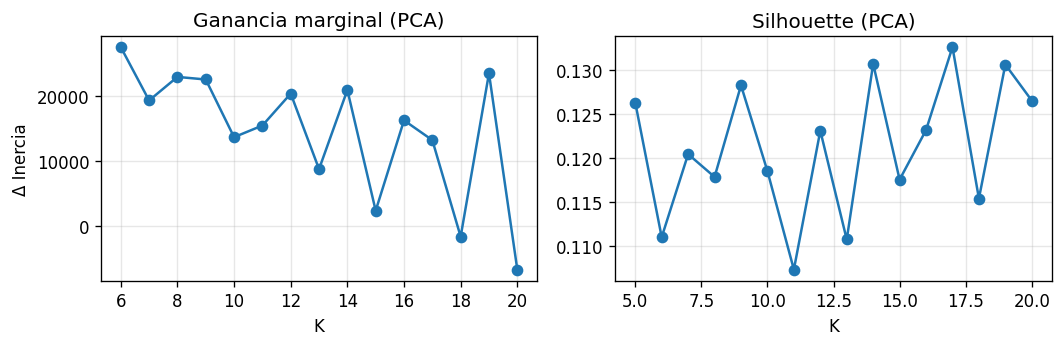

Elbow (umbral relativo): 6 | Elbow (2da dif): 20 | Silhouette max: 17


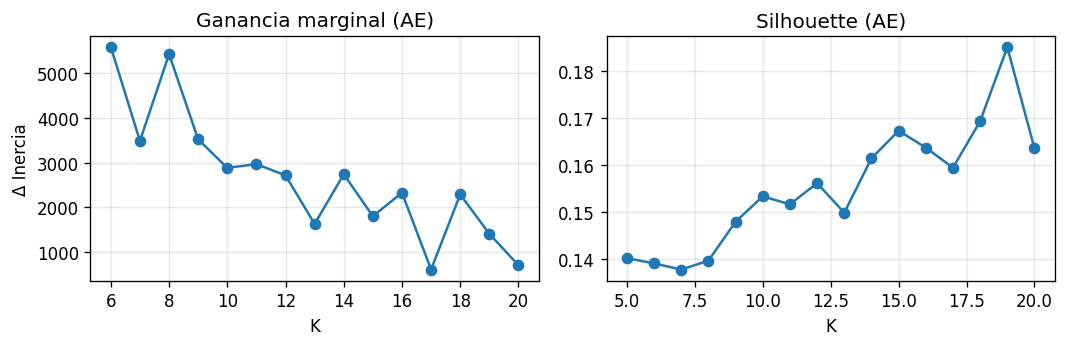

Elbow (umbral relativo): 7 | Elbow (2da dif): 7 | Silhouette max: 19
K k-means final | PCA: 6  | AE: 7


In [6]:
# ====== Celda 6: k-means sweep & elbow ======
Ks = range(5, 21)

def kmeans_sweep(Z, Ks):
    inertias, sils = [], []
    for K in Ks:
        km = KMeans(n_clusters=K, n_init=8, random_state=RNG_SEED).fit(Z)
        inertias.append(km.inertia_)
        sils.append(silhouette_score_robust(Z, km.labels_))
    return np.array(inertias), np.array(sils)

inertia_pca, sil_pca = kmeans_sweep(Ztr_pca, Ks)
inertia_ae,  sil_ae  = kmeans_sweep(z_tr,    Ks)

def plot_kmeans_selection(Ks, inertia, silhouette, title_suffix=""):
    from math import isnan
    # ganancias marginales
    gains = np.full_like(inertia, np.nan, float)
    gains[1:] = inertia[:-1] - inertia[1:]
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    ax[0].plot(list(Ks), gains, marker="o"); ax[0].set_title(f"Ganancia marginal {title_suffix}")
    ax[0].set_xlabel("K"); ax[0].set_ylabel("Δ Inercia"); ax[0].grid(True, alpha=0.3)
    m = ~np.isnan(silhouette)
    ax[1].plot(np.array(list(Ks))[m], silhouette[m], marker="o")
    ax[1].set_title(f"Silhouette {title_suffix}"); ax[1].set_xlabel("K"); ax[1].grid(True, alpha=0.3)
    showfig(fig)
    k_rel, k_dd, diag = select_k_by_elbow(inertia, Ks, rel_thresh=0.05)
    k_sil = np.array(list(Ks))[m][np.nanargmax(silhouette[m])] if m.any() else None
    print(f"Elbow (umbral relativo): {k_rel} | Elbow (2da dif): {k_dd} | Silhouette max: {k_sil}")
    return k_rel, k_dd, k_sil

krel_p, kdd_p, ksil_p = plot_kmeans_selection(Ks, inertia_pca, sil_pca, "(PCA)")
krel_a, kdd_a, ksil_a = plot_kmeans_selection(Ks, inertia_ae,  sil_ae,  "(AE)")

K_km_pca = min(krel_p, kdd_p)  # conservador
K_km_ae  = min(krel_a, kdd_a)
print("K k-means final | PCA:", K_km_pca, " | AE:", K_km_ae)


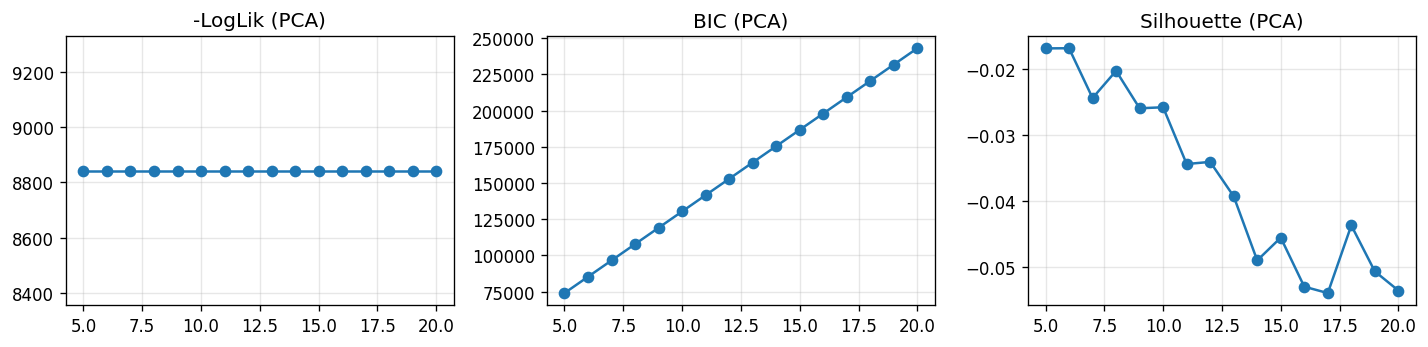

K por BIC: 5 | K por Silhouette: 6


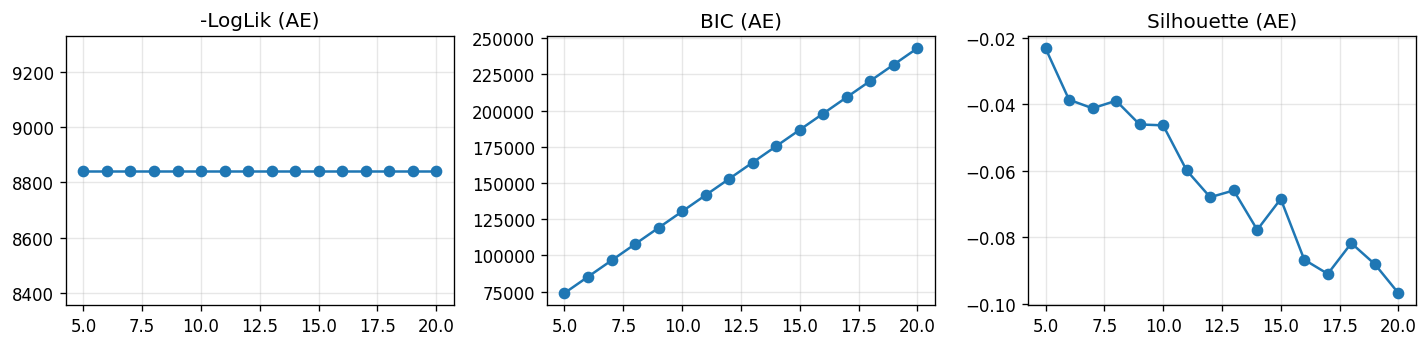

K por BIC: 5 | K por Silhouette: 5
K GMM final | PCA: 5  | AE: 5


In [7]:
# ====== Celda 7: GMM sweep (BIC + silhouette) ======
def zstd_fit(Z):
    mu=Z.mean(0,keepdims=True); sd=Z.std(0,ddof=1,keepdims=True); sd[sd==0]=1.0
    return {"mu":mu,"sd":sd}
def zstd_tf(Z, st): return (Z-st["mu"])/st["sd"]

def gmm_num_params(D, K):
    return (K-1) + K*D + K*(D*(D+1)//2)  # full; usamos diag pero BIC es proxy ok

def gmm_sweep(Z, Ks, n_init=8, reg=1e-2, cov="diag", seed=RNG_SEED):
    N,D = Z.shape
    logliks, bics, sils = [], [], []
    for K in Ks:
        # múltiples reinicios, kmeans init en el primero
        best_ll=-np.inf; best_labs=None
        km = KMeans(n_clusters=K, n_init=5, random_state=seed).fit(Z)
        inits = [km.cluster_centers_]
        for _ in range(n_init-1):
            idx = rng.choice(N, size=K, replace=False); inits.append(Z[idx].copy())
        for init in inits:
            gmm = GMM(n_components=K, reg_covar=reg, random_state=seed, init_means=init, cov_type=cov).fit(Z)
            if gmm.loglik_ > best_ll:
                best_ll=gmm.loglik_; best_labs=gmm.predict(Z)
        p = gmm_num_params(D,K)
        bic = -2*best_ll + p*np.log(N)
        uniq, counts = np.unique(best_labs, return_counts=True)
        sil = np.nan if (len(uniq)<2 or (counts<2).any()) else silhouette_score_robust(Z, best_labs)
        logliks.append(best_ll); bics.append(bic); sils.append(sil)
    return np.array(logliks), np.array(bics), np.array(sils)

# estandarizamos latentes antes del GMM
st_p = zstd_fit(Ztr_pca); Ztr_pca_gmm = zstd_tf(Ztr_pca, st_p)
st_a = zstd_fit(z_tr);    Ztr_ae_gmm  = zstd_tf(z_tr,    st_a)

ll_p, bic_p, sil_p = gmm_sweep(Ztr_pca_gmm, Ks, n_init=10, reg=1e-2, cov="diag")
ll_a, bic_a, sil_a = gmm_sweep(Ztr_ae_gmm,  Ks, n_init=10, reg=1e-2, cov="diag")

def plot_gmm_selection(Ks, ll, bic, silhouette, title_suffix=""):
    Ks = np.array(list(Ks))
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    ax[0].plot(Ks, -ll,  marker="o"); ax[0].set_title(f"-LogLik {title_suffix}"); ax[0].grid(True, alpha=0.3)
    ax[1].plot(Ks, bic, marker="o"); ax[1].set_title(f"BIC {title_suffix}"); ax[1].grid(True, alpha=0.3)
    m = ~np.isnan(silhouette)
    ax[2].plot(Ks[m], silhouette[m], marker="o"); ax[2].set_title(f"Silhouette {title_suffix}"); ax[2].grid(True, alpha=0.3)
    showfig(fig)
    k_bic = int(Ks[np.argmin(bic)])
    k_sil = int(Ks[m][np.nanargmax(silhouette[m])]) if m.any() else None
    print(f"K por BIC: {k_bic} | K por Silhouette: {k_sil}")
    return k_bic, k_sil

k_bic_pca, k_sil_pca = plot_gmm_selection(Ks, ll_p, bic_p, sil_p, "(PCA)")
k_bic_ae,  k_sil_ae  = plot_gmm_selection(Ks, ll_a, bic_a, sil_a, "(AE)")

K_gmm_pca = k_bic_pca if k_sil_pca is None else k_bic_pca  # quedate con BIC por defecto
K_gmm_ae  = k_bic_ae  if k_sil_ae  is None else k_bic_ae
print("K GMM final | PCA:", K_gmm_pca, " | AE:", K_gmm_ae)


Tamaños kmeans-PCA:
1    78
4    63
3    53
2    48
0    40
5    38

Tamaños kmeans-AE:
3    65
6    59
1    46
4    40
5    39
2    37
0    34

Tamaños GMM-PCA:
4    77
2    68
3    63
1    57
0    55

Tamaños GMM-AE:
4    77
2    68
3    63
1    57
0    55

Pureza ponderada kmeans-PCA: 0.147
Pureza ponderada kmeans-AE: 0.166
Pureza ponderada GMM-PCA: 0.066
Pureza ponderada GMM-AE: 0.066


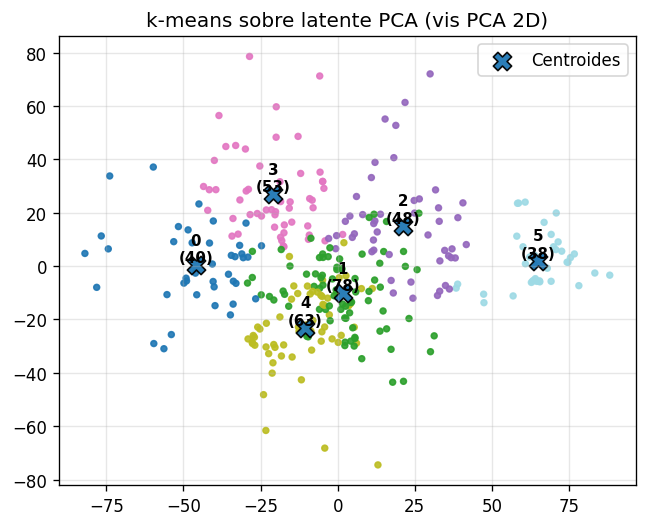

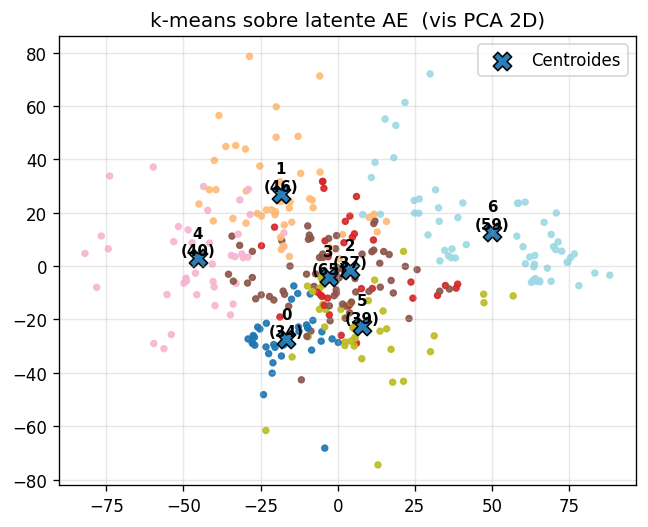

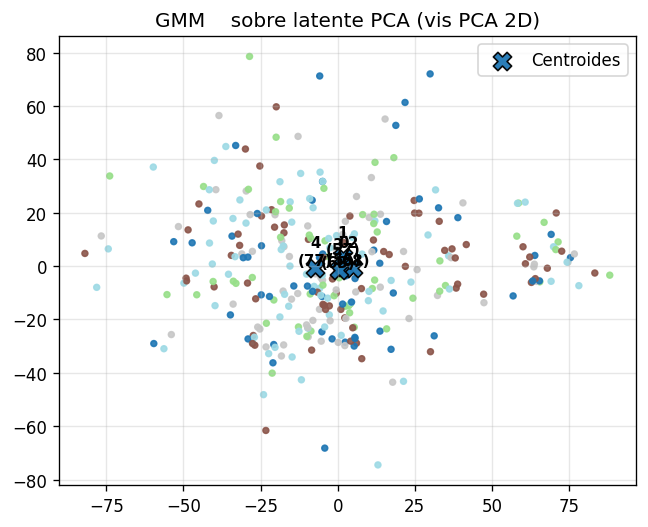

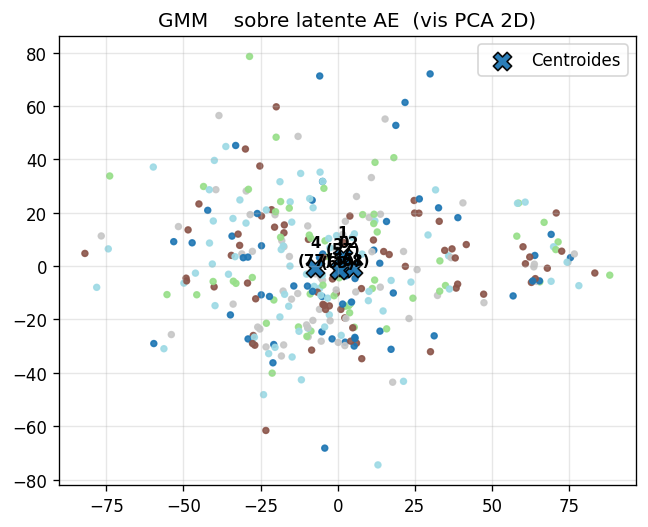

In [8]:
# ====== Celda 8: Fit final, pureza y visualización ======
# k-means finales
km_p = KMeans(n_clusters=K_km_pca, n_init=10, random_state=RNG_SEED).fit(Ztr_pca)
km_a = KMeans(n_clusters=K_km_ae,  n_init=10, random_state=RNG_SEED).fit(z_tr)

# GMM finales (robustos)
gmm_p = GMM(n_components=K_gmm_pca, reg_covar=1e-2, random_state=RNG_SEED,
            init_means=KMeans(K_gmm_pca, n_init=5, random_state=RNG_SEED).fit(Ztr_pca_gmm).cluster_centers_,
            cov_type="diag").fit(Ztr_pca_gmm)
gmm_a = GMM(n_components=K_gmm_ae,  reg_covar=1e-2, random_state=RNG_SEED,
            init_means=KMeans(K_gmm_ae,  n_init=5, random_state=RNG_SEED).fit(Ztr_ae_gmm ).cluster_centers_,
            cov_type="diag").fit(Ztr_ae_gmm)

labs_km_p = km_p.labels_
labs_km_a = km_a.labels_
labs_gm_p = gmm_p.predict(Ztr_pca_gmm)
labs_gm_a = gmm_a.predict(Ztr_ae_gmm)

def cluster_sizes(labels, name=""):
    uniq, counts = np.unique(labels, return_counts=True)
    s = pd.Series(counts, index=uniq, name="size").sort_values(ascending=False)
    print(f"Tamaños {name}:\n{s.to_string()}\n")
cluster_sizes(labs_km_p, "kmeans-PCA")
cluster_sizes(labs_km_a, "kmeans-AE")
cluster_sizes(labs_gm_p, "GMM-PCA")
cluster_sizes(labs_gm_a, "GMM-AE")

# pureza y crosstab
def purity_weighted_mean(labels, y_true):
    tab = pd.crosstab(pd.Series(labels, name="cluster"), pd.Series(y_true, name="class"))
    purity = (tab.max(axis=1) / tab.sum(axis=1))
    pwm = float((purity * tab.sum(axis=1) / tab.sum().sum()).sum())
    return pwm, tab, purity

for name, labs in [("kmeans-PCA", labs_km_p), ("kmeans-AE", labs_km_a), ("GMM-PCA", labs_gm_p), ("GMM-AE", labs_gm_a)]:
    pwm, tab, purity = purity_weighted_mean(labs, ytr)
    print(f"Pureza ponderada {name}: {pwm:.3f}")

# Visualización 2D (PCA de visualización) coloreando por cluster y con centroides
pca2 = pca_fit(Xtr_std)            # usamos PCA solo para plot
Z2   = pca_transform(Xtr_std, pca2, k=2)

def plot_clusters_2d_by_label(Z2, labels, title="Clusters 2D"):
    labels = np.asarray(labels)
    uniq = np.unique(labels); K = uniq.size
    cmap = plt.get_cmap("tab20", K)
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    sc = ax.scatter(Z2[:,0], Z2[:,1], c=labels, s=12, cmap=cmap, vmin=uniq.min(), vmax=uniq.max(), alpha=0.9)
    centroids = np.vstack([Z2[labels==k].mean(axis=0) for k in uniq])
    ax.scatter(centroids[:,0], centroids[:,1], marker="X", s=120, edgecolor="k", linewidths=1.0, alpha=0.95, label="Centroides")
    sizes = {int(k): int((labels==k).sum()) for k in uniq}
    for k,(cx,cy) in zip(uniq, centroids):
        ax.text(cx, cy, f"{k}\n({sizes[int(k)]})", ha="center", va="bottom", fontsize=9, weight="bold")
    ax.set_title(title); ax.grid(True, alpha=0.3); ax.legend(loc="best")
    showfig(fig)

plot_clusters_2d_by_label(Z2, labs_km_p, "k-means sobre latente PCA (vis PCA 2D)")
plot_clusters_2d_by_label(Z2, labs_km_a, "k-means sobre latente AE  (vis PCA 2D)")
plot_clusters_2d_by_label(Z2, labs_gm_p, "GMM    sobre latente PCA (vis PCA 2D)")
plot_clusters_2d_by_label(Z2, labs_gm_a, "GMM    sobre latente AE  (vis PCA 2D)")


In [9]:
# ====== Celda 9: evaluación en test (opcional) ======
# Transformaciones a test
Zte_pca = pca_transform(Xte_std, pca, k=k_pca)
Zte_pca_gmm = zstd_tf(Zte_pca, st_p)

z_te = z_te  # ya calculado con el AE
Zte_ae_gmm = zstd_tf(z_te, st_a)

# Predicción y silhouette en test
labs_km_p_te = km_p.predict(Zte_pca)
labs_km_a_te = km_a.predict(z_te)
labs_gm_p_te = gmm_p.predict(Zte_pca_gmm)
labs_gm_a_te = gmm_a.predict(Zte_ae_gmm)

def sil_if_valid(Z, labs):
    u,c = np.unique(labs, return_counts=True)
    return np.nan if (len(u)<2 or (c<2).any()) else silhouette_score_robust(Z, labs)

print("Silhouette test | kmeans-PCA:", sil_if_valid(Zte_pca, labs_km_p_te))
print("Silhouette test | kmeans-AE :", sil_if_valid(z_te,    labs_km_a_te))
print("Silhouette test | GMM-PCA   :", sil_if_valid(Zte_pca_gmm, labs_gm_p_te))
print("Silhouette test | GMM-AE    :", sil_if_valid(Zte_ae_gmm,  labs_gm_a_te))


Silhouette test | kmeans-PCA: 0.10422637652436606
Silhouette test | kmeans-AE : 0.14332320320245345
Silhouette test | GMM-PCA   : -0.030352043622406198
Silhouette test | GMM-AE    : -0.06291381341288797


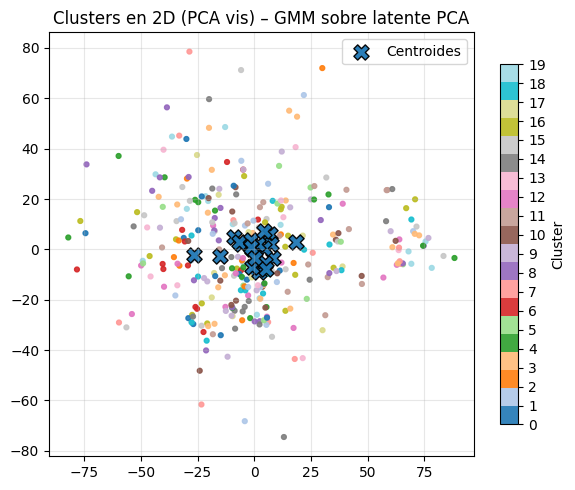

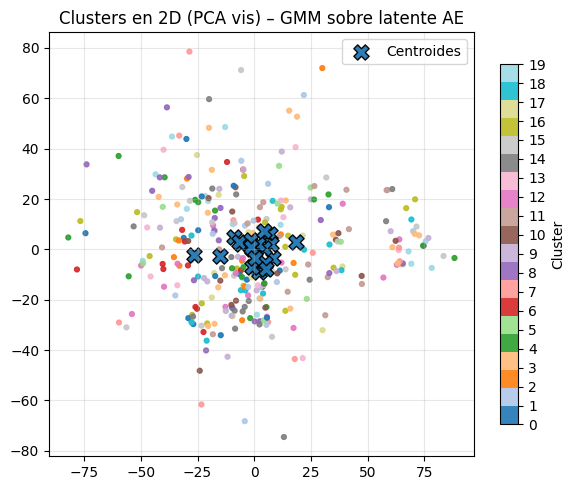

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# PCA 2D solo para visualizar
pca2 = pre.pca_fit(Xtr_std)
Z2 = pre.pca_transform(Xtr_std, pca2, k=2)

def plot_clusters_2d_by_label(Z2, labels, title="Clusters en 2D"):
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    K = uniq.size
    cmap = plt.get_cmap("tab20", K)  # mapa discreto con K colores

    # scatter coloreado por cluster
    plt.figure(figsize=(6,5))
    sc = plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=12, cmap=cmap, vmin=uniq.min(), vmax=uniq.max(), alpha=0.9)
    cbar = plt.colorbar(sc, ticks=uniq, shrink=0.85)
    cbar.set_label("Cluster")

    # centroides en el espacio de visualización (promedio por etiqueta)
    centroids = np.vstack([Z2[labels==k].mean(axis=0) for k in uniq])
    plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=120, edgecolor="k", linewidths=1.0, alpha=0.95, label="Centroides")

    # anotá tamaño de cada cluster (opcional)
    sizes = {int(k): int((labels==k).sum()) for k in uniq}
    #for k, (cx, cy) in zip(uniq, centroids):
        #plt.text(cx, cy, f"{k}\n({sizes[int(k)]})", ha="center", va="bottom", fontsize=9, weight="bold")

    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()

# usá las etiquetas correctas del GMM que elegiste:
plot_clusters_2d_by_label(Z2, labels_pca, "Clusters en 2D (PCA vis) – GMM sobre latente PCA")
plot_clusters_2d_by_label(Z2, labels_ae,  "Clusters en 2D (PCA vis) – GMM sobre latente AE")
